# Replication of results of authors

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm


/opt/homebrew/Caskroom/miniconda/base/envs/conda_ipynb_env/lib/python3.11/site-packages/librosa/util/files.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [2]:
PROJECT_ROOT = Path.cwd().resolve().parent
DATA_DIR = PROJECT_ROOT / "data" / "raw" / "recordings"
FIGURES_DIR = PROJECT_ROOT / "figures"

FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_DIR:", DATA_DIR)
print("Number of wav files:", len(list(DATA_DIR.glob("*.wav"))))

DATA_DIR: /Users/aleksandrasuvorova/Documents/GitHub/ML-tasks/Chaos_Net/data/raw/recordings
Number of wav files: 3000


In [3]:
def parse_filename(fname: str):
    """
    Parse FSDD filename: {digit}_{speaker}_{index}.wav
    """
    name = fname.replace(".wav", "")
    digit, speaker, index = name.split("_", 2)
    return int(digit), speaker, int(index)

# Быстрая проверка на одном файле
example_file = next(DATA_DIR.glob("*.wav"))
parse_filename(example_file.name)

(5, 'nicolas', 9)

In [4]:
records = []

for wav_path in tqdm(sorted(DATA_DIR.glob("*.wav"))):
    digit, speaker, index = parse_filename(wav_path.name)
    
    # librosa.load -> sr=None, чтобы не ресемплить
    signal, sr = librosa.load(wav_path, sr=None)
    
    records.append({
        "file": wav_path.name,
        "digit": digit,
        "speaker": speaker,
        "length": len(signal),
        "sr": sr
    })

df = pd.DataFrame(records)
df.head()


100%|██████████| 3000/3000 [00:00<00:00, 8864.25it/s]


,file,digit,speaker,length,sr
0,0_george_0.wav,0,george,2384,8000
1,0_george_1.wav,0,george,4727,8000
2,0_george_10.wav,0,george,5958,8000
3,0_george_11.wav,0,george,3661,8000
4,0_george_12.wav,0,george,4050,8000


In [5]:
print("Total samples:", len(df))
print("Digits:", sorted(df["digit"].unique()))
print("Number of speakers:", df["speaker"].nunique())
print("Speakers:", sorted(df["speaker"].unique()))
print("\nSamples per speaker:")
display(df["speaker"].value_counts())


Total samples: 3000
Digits: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
Number of speakers: 6
Speakers: ['george', 'jackson', 'lucas', 'nicolas', 'theo', 'yweweler']

Samples per speaker:


speaker
george      500
jackson     500
lucas       500
nicolas     500
theo        500
yweweler    500
Name: count, dtype: int64

Авторы в статье обрезают все сигналы до минимальной длины — мы делаем то же самое.

In [6]:
min_length = df["length"].min()
max_length = df["length"].max()
mean_length = df["length"].mean()

min_length, max_length, mean_length


(1148, 18262, np.float64(3499.4746666666665))

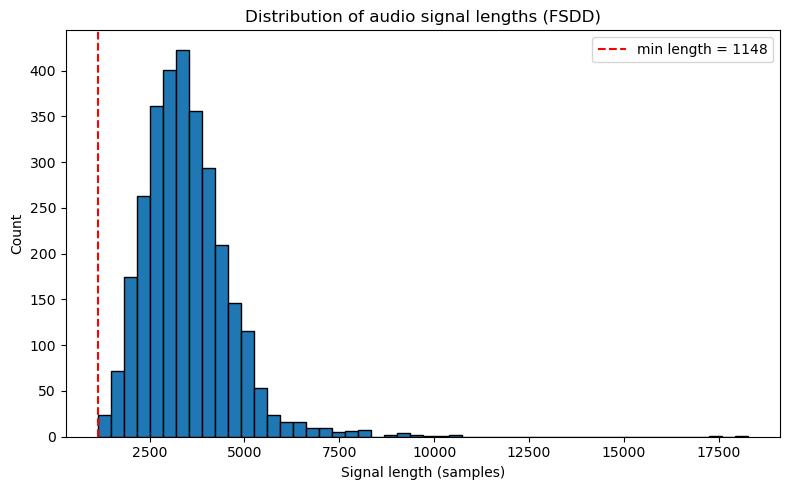

Saved to: /Users/aleksandrasuvorova/Documents/GitHub/ML-tasks/Chaos_Net/figures/fsdd_signal_length_distribution.png


In [7]:
plt.figure(figsize=(8, 5))
plt.hist(df["length"], bins=50, edgecolor="black")
plt.axvline(min_length, color="red", linestyle="--", label=f"min length = {min_length}")
plt.xlabel("Signal length (samples)")
plt.ylabel("Count")
plt.title("Distribution of audio signal lengths (FSDD)")
plt.legend()
plt.tight_layout()

out_path = FIGURES_DIR / "fsdd_signal_length_distribution.png"
plt.savefig(out_path, dpi=150)
plt.show()

print("Saved to:", out_path)


In [8]:
BASELINE_SPEAKER = "jackson"

df_baseline = df[df["speaker"] == BASELINE_SPEAKER].copy()

print("Baseline speaker:", BASELINE_SPEAKER)
print("Total samples:", len(df_baseline))
print("\nSamples per digit:")
display(df_baseline["digit"].value_counts().sort_index())


Baseline speaker: jackson
Total samples: 500

Samples per digit:


digit
0    50
1    50
2    50
3    50
4    50
5    50
6    50
7    50
8    50
9    50
Name: count, dtype: int64

In [9]:
def load_and_trim(wav_path, target_length):
    signal, sr = librosa.load(wav_path, sr=None)
    if len(signal) < target_length:
        raise ValueError("Signal shorter than target length")
    return signal[:target_length]


In [10]:
# Загружаем все сигналы baseline-спикера
signals = []
labels = []

for _, row in tqdm(df_baseline.iterrows(), total=len(df_baseline)):
    wav_path = DATA_DIR / row["file"]
    sig = load_and_trim(wav_path, min_length)
    
    signals.append(sig)
    labels.append(row["digit"])

signals = np.stack(signals)   # shape: (N, min_length)
labels = np.array(labels)

signals.shape, labels.shape


100%|██████████| 500/500 [00:00<00:00, 8408.89it/s]


((500, 1148), (500,))

В статье сказано: *normalized Fourier coefficients*

Без деталей. Поэтому мы выбираем самый нейтральный и воспроизводимый вариант:

FFT по времени,
модуль спектра,
только положительные частоты,
L2-нормировка.

In [44]:
def fft_features(signal):
    """
    Compute normalized Fourier magnitude coefficients.
    """
    spectrum = np.fft.rfft(signal)
    magnitude = np.abs(spectrum)
    
    # L2 normalization
    norm = np.linalg.norm(magnitude)
    if norm > 0:
        magnitude = magnitude / norm
    
    return magnitude


In [12]:
# Проверка на одном сигнале
feat_example = fft_features(signals[0])
feat_example.shape


(575,)

In [13]:
X = np.stack([fft_features(sig) for sig in tqdm(signals)])
y = labels.copy()

X.shape, y.shape


100%|██████████| 500/500 [00:00<00:00, 58714.15it/s]


((500, 575), (500,))

In [14]:
print("X min:", X.min())
print("X max:", X.max())
print("Mean feature norm:", np.mean(np.linalg.norm(X, axis=1)))


X min: 2.6716239e-06
X max: 0.7983808
Mean feature norm: 1.0


In [24]:
def prepare_for_chaosfex(X):
    """
    EXACTLY as expected by ChaosFEX:
    - 2D array
    - float64
    - values in [0, 1]
    """
    X = np.asarray(X, dtype=np.float64)

    X_min = X.min(axis=1, keepdims=True)
    X_max = X.max(axis=1, keepdims=True)

    X_norm = (X - X_min) / (X_max - X_min + 1e-12)

    return X_norm


In [25]:
X_norm = prepare_for_chaosfex(X)

print(X_norm.shape)
print(X_norm.dtype)
print("min/max:", X_norm.min(), X_norm.max())


(500, 575)
float64
min/max: 0.0 0.9999999999987474


In [17]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve().parent
SR_PATH = PROJECT_ROOT / "repos" / "sr_nl"

sys.path.append(str(SR_PATH))

import ChaosFEX.feature_extractor as CFX

print("ChaosFEX loaded from:", CFX.__file__)


> Numba JIT warmup successful for chaotic_sampler ...
> Numba JIT warmup successful for transform ...
ChaosFEX loaded from: /Users/aleksandrasuvorova/Documents/GitHub/ML-tasks/Chaos_Net/repos/sr_nl/ChaosFEX/feature_extractor.py


In [18]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def chaosnet_decision(traindata, trainlabel, testdata):
    """
    1:1 copy of chaosnet() from Codes.py
    """
    NUM_FEATURES = traindata.shape[1]
    NUM_CLASSES = len(np.unique(trainlabel))

    mean_each_class = np.zeros((NUM_CLASSES, NUM_FEATURES))

    for label in range(NUM_CLASSES):
        mean_each_class[label, :] = np.mean(
            traindata[(trainlabel == label), :],
            axis=0
        )

    predicted_label = np.argmax(
        cosine_similarity(testdata, mean_each_class),
        axis=1
    )

    return predicted_label


In [19]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split


In [26]:
def run_sr_experiment(
    X, y,
    q=0.34,
    b=0.499,
    epsilon=1e-3,          # ⬅️ минимум допустимый
    chaos_length=10000,
    test_size=0.3,
    random_state=42
):
    if epsilon <= 0:
        raise ValueError("epsilon must be > 0 (ChaosFEX constraint)")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )

    F_train = CFX.transform(X_train, q, chaos_length, epsilon, b)
    F_test  = CFX.transform(X_test,  q, chaos_length, epsilon, b)

    if F_train is None or F_test is None:
        raise RuntimeError("ChaosFEX.transform returned None — check epsilon range")

    y_pred = chaosnet_decision(F_train, y_train, F_test)

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average="macro")

    return acc, f1


In [27]:
acc0, f10 = run_sr_experiment(
    X_norm, y,
    q=0.34,
    b=0.499,
    epsilon=1e-3
)

acc0, f10


(0.14666666666666667, 0.13671954633644545)

In [28]:
baseline_acc = acc0
baseline_f1  = f10

baseline_acc, baseline_f1


(0.14666666666666667, 0.13671954633644545)

In [29]:
EPSILON = np.arange(0.001, 1.001, 0.001)


In [30]:
eps_values = np.arange(0.001, 1.001, 0.001)

acc_list = []
f1_list  = []

for eps in eps_values:
    acc, f1 = run_sr_experiment(
        X_norm, y,
        q=0.34,
        b=0.499,
        epsilon=eps
    )
    acc_list.append(acc)
    f1_list.append(f1)

acc_list = np.array(acc_list)
f1_list  = np.array(f1_list)


In [31]:
f1_list.min(), f1_list.max()


(np.float64(0.01818181818181818), np.float64(0.8405747448640696))

In [37]:
import numpy as np

# диапазон шумов как в статье
epsilon_grid = np.arange(0.001, 1.001, 0.001)

f1_scores = []

for eps in epsilon_grid:
    acc, f1 = run_sr_experiment(
        X_norm, y,
        q=0.34,
        b=0.499,
        epsilon=eps
    )
    f1_scores.append(f1)

f1_scores = np.array(f1_scores)

# baseline = минимальный шум
baseline_f1 = f1_scores[0]

print("Baseline F1:", baseline_f1)
print("Best F1:", f1_scores.max())
print("Best epsilon:", epsilon_grid[np.argmax(f1_scores)])


Baseline F1: 0.13671954633644545
Best F1: 0.8405747448640696
Best epsilon: 0.168


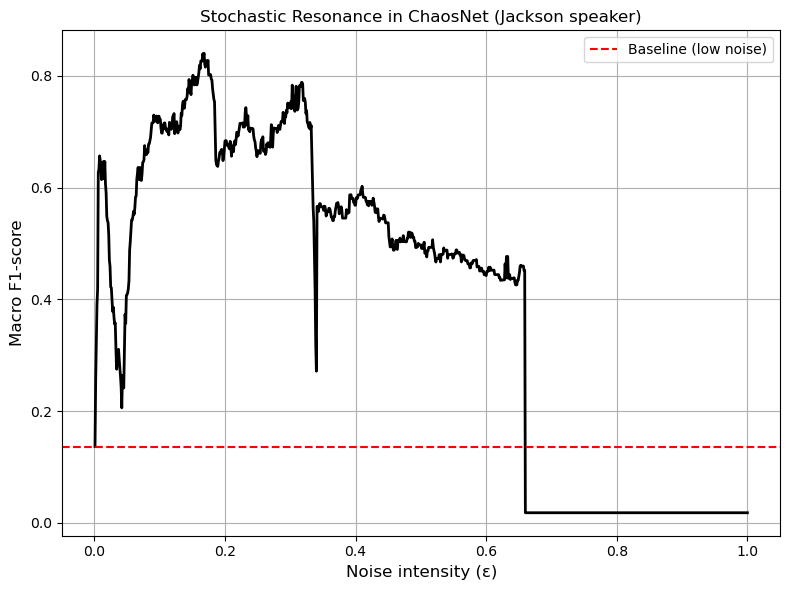

Saved to ../figures/SR_single_split_Jackson.png


In [38]:
import os
import matplotlib.pyplot as plt

FIG_DIR = "../figures"
os.makedirs(FIG_DIR, exist_ok=True)

plt.figure(figsize=(8, 6))
plt.plot(epsilon_grid, f1_scores, color="black", linewidth=2)
plt.axhline(
    y=baseline_f1,
    color="red",
    linestyle="--",
    label="Baseline (low noise)"
)

plt.xlabel("Noise intensity (ε)", fontsize=12)
plt.ylabel("Macro F1-score", fontsize=12)
plt.title("Stochastic Resonance in ChaosNet (Jackson speaker)")
plt.grid(True)
plt.legend()

save_path = os.path.join(FIG_DIR, "SR_single_split_Jackson.png")
plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()

print(f"Saved to {save_path}")


In [39]:
best_idx = np.argmax(f1_list)

best_eps = eps_values[best_idx]
best_f1  = f1_list[best_idx]
best_acc = acc_list[best_idx]

best_eps, best_f1, best_acc


(np.float64(0.168),
 np.float64(0.8405747448640696),
 np.float64(0.8466666666666667))

In [41]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

def run_sr_experiment_kfold(X, y, q, b, epsilon, chaos_length=10000):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        F_train = CFX.transform(X_train, q, chaos_length, epsilon, b)
        F_test  = CFX.transform(X_test,  q, chaos_length, epsilon, b)

        y_pred = chaosnet_decision(F_train, y_train, F_test)
        f1 = f1_score(y_test, y_pred, average="macro")
        f1_scores.append(f1)

    return np.mean(f1_scores)


In [42]:
epsilon_grid = np.arange(0.001, 1.001, 0.001)
f1_kfold = []

for eps in epsilon_grid:
    f1 = run_sr_experiment_kfold(
        X_norm, y,
        q=0.34,
        b=0.499,
        epsilon=eps
    )
    f1_kfold.append(f1)

f1_kfold = np.array(f1_kfold)

print("Best k-fold F1:", f1_kfold.max())
print("Best epsilon:", epsilon_grid[np.argmax(f1_kfold)])


Best k-fold F1: 0.8308061614828082
Best epsilon: 0.176


In [47]:
np.savez(
    "../figures/SR_kfold_jackson_rs42.npz",
    epsilon=epsilon_grid,
    f1=f1_kfold
)
print("Saved results for random_state=42")



Saved results for random_state=42


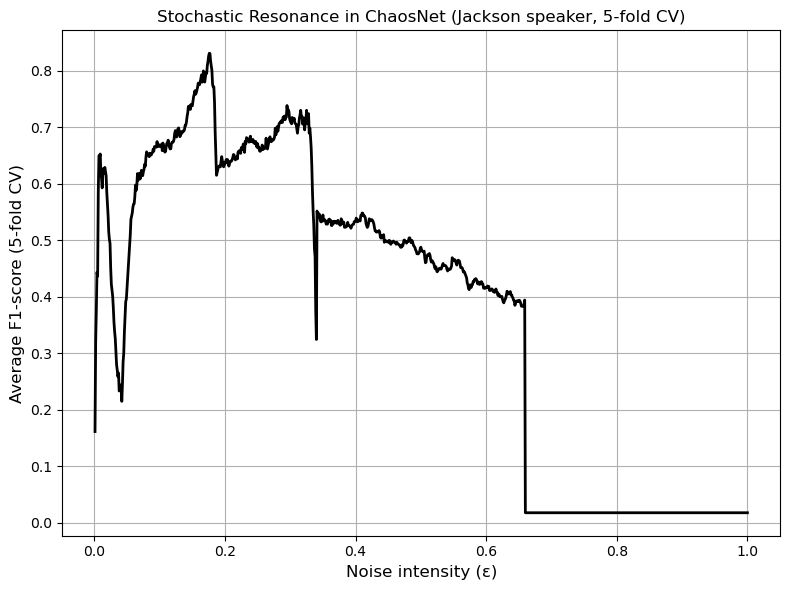

Saved to ../figures/SR_kfold_Jackson.png


In [45]:
plt.figure(figsize=(8, 6))
plt.plot(epsilon_grid, f1_kfold, color="black", linewidth=2)

plt.xlabel("Noise intensity (ε)", fontsize=12)
plt.ylabel("Average F1-score (5-fold CV)", fontsize=12)
plt.title("Stochastic Resonance in ChaosNet (Jackson speaker, 5-fold CV)")
plt.grid(True)

save_path = "../figures/SR_kfold_Jackson.png"
plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()

print(f"Saved to {save_path}")
